## Deep Learning Spring 2025: CIFAR 10 classification - Final Model
#### Pooja Gayathri Kanala - pk2921<br> Srushti Shah - ss17021<br> Subhiksha Seshadri Nallore - ssn9077

In [ ]:
#Importing the required libraries
import numpy as np
import pandas as pd
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch.optim.lr_scheduler import StepLR, MultiStepLR
from PIL import Image
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

In [ ]:
# This contains the EnhancedCIFAR10Dataset class and the data loading process.
# It also includes the data augmentation and normalization transformations for both training and testing datasets.
# Additionally, it creates the training, validation, and test data loaders.

# Load and process CIFAR-10 dataset
def cifar_batch_loader(file):
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')

# Set CIFAR-10 directory and load metadata
cifar10_dir = 'cifar-10-batches-py'
meta = cifar_batch_loader(os.path.join(cifar10_dir, 'batches.meta'))
label_names = [label.decode('utf-8') for label in meta[b'label_names']]

# Define EnhancedCIFAR10Dataset class
class EnhancedCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, data_batches=None, transform=None, test=False):
        self.transform = transform
        
        if test:
            # Load test data
            batch = cifar_batch_loader(os.path.join(cifar10_dir, 'test_batch'))
            self.images = batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
            self.labels = np.array(batch[b'labels'])
        elif data_batches:
            # Use provided data
            self.images = data_batches[0]
            self.labels = data_batches[1]
        else:
            # Load training data
            data, labels = [], []
            for i in range(1, 6):
                batch = cifar_batch_loader(os.path.join(cifar10_dir, f'data_batch_{i}'))
                data.append(batch[b'data'])
                labels.extend(batch[b'labels'])
            
            self.images = np.vstack(data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
            self.labels = np.array(labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
            
        return img, label

# Create datasets
# Define the transformations for the training dataset
train_transform = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.RandomRotation(10),  
    transforms.ColorJitter(0.1, 0.1, 0.1), 
    transforms.RandomHorizontalFlip(), 
    transforms.RandomAdjustSharpness(2, 0.2),  
    transforms.RandomCrop(32, 4),  
    transforms.ToTensor(),  
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),  
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=1.0)  
])

# Define the transformations for the test dataset
test_transform = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.ToTensor(),  
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Normalize the image with mean and std
])

# Create the full training dataset with transformations
train_full = EnhancedCIFAR10Dataset(transform=train_transform)

# Create the test dataset with transformations
test_dataset = EnhancedCIFAR10Dataset(test=True, transform=test_transform)

# Split the full training dataset into training and validation datasets
train_size = int(0.9 * len(train_full))  # 90% for training
val_size = len(train_full) - train_size  # 10% for validation
train_dataset, val_dataset = random_split(train_full, [train_size, val_size])  # Split the dataset

# Create data loaders for training, validation, and testing datasets
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
    ResidualBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14

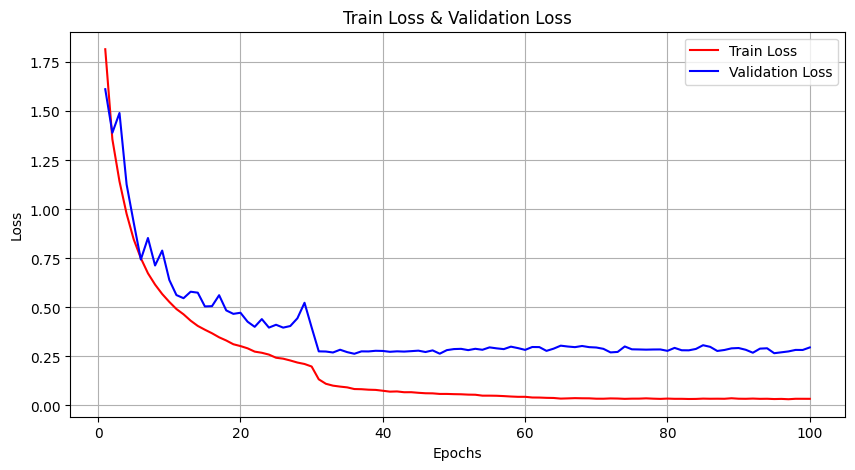

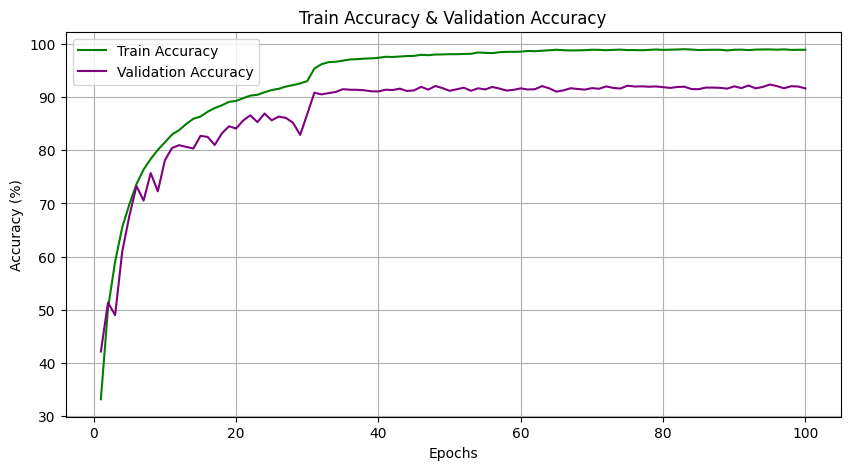

In [ ]:
# Define a custom ResNet model from scratch
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # Skip connection
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x 
        if self.skip:
            identity = self.skip(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        # Initial convolutional layer
        self.init_conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.init_bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # Residual layers
        self.layer1 = self._make_layer(64, 64, 4, stride=1)
        self.layer2 = self._make_layer(64, 128, 4, stride=2)
        self.layer3 = self._make_layer(128, 256, 3, stride=2)
        # Adaptive average pooling and fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.init_conv(x)
        out = self.init_bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out
    

# Automatically choose CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Put model on the selected device (CPU/GPU)
model = CustomResNet().to(device)

# Print the number of parameters
from torchsummary import summary
summary(model, (3, 32, 32))

# Training implementation without function wrapper
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=0.9, weight_decay=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[30, 60, 80, 90], gamma=0.1)

# Lists to store losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 100  # Change epoch count here

for epoch in range(epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step()
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='red')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss & Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train Accuracy & Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Test Evaluation
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 93.20%


In [ ]:
import pandas as pd

# Load test dataset
cifar_test_path = 'cifar_test_nolabel.pkl'
test_batch = load_cifar_batch(cifar_test_path)
test_images = test_batch[b'data'].astype(np.float32) / 255.0  # Normalize the test images

# Convert test dataset to Tensor
test_dataset = [(test_transform(img),) for img in test_images]  # Apply test transformations
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)  # Create DataLoader for test dataset

model.eval()  # Set the model to evaluation mode
predictions = []
with torch.no_grad():  # Disable gradient calculation for inference
    for batch in test_loader:
        images = batch[0].to(device)  # Move images to the appropriate device (CPU/GPU)
        outputs = model(images)  # Get model predictions
        _, predicted = torch.max(outputs, 1)  # Get the predicted class labels
        predictions.extend(predicted.cpu().numpy())  # Store predictions

# Generate submission file
submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})  # Create a DataFrame for submission
submission.to_csv('submission6.csv', index=False)  # Save the DataFrame to a CSV file
print("Submission6 file saved.")

Submission6 file saved.
